# 요약
- 4가지 전처리 모델을 비교
- blazeface는 폴더통째 첨부됨
- MTCNN
  - pip 인스톨로 설치
- yolo, mobilenet
  - 첨부됨

In [0]:
### 데이터랑 모델이랑 같은 폴더에 들어있는 구조
### 코렙이나 케글에 따라 주석풀고 사용
# path = '/kaggle/input/'
path = '/content/drive/My Drive/data/face/'
### 예시
# video = path + 'jennie_grayscale.mp4'

# Imports

In [0]:
import os
import sys
import math
import time
import cv2
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
from matplotlib.patches import Rectangle

import torch
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Initialize BlazeFace
source : https://www.kaggle.com/humananalog/starter-blazeface-pytorch

In [0]:
sys.path.insert(0, path+"BlazeFace_PyTorch")
from blazeface import BlazeFace

In [0]:
# 동일환경하 비교를 위해 주석처리
# gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# blazeface = BlazeFace().to(gpu)
blazeface = BlazeFace().to()
blazeface.load_weights(path+"BlazeFace_PyTorch/blazeface.pth")
blazeface.load_anchors(path+"BlazeFace_PyTorch/anchors.npy")

# Optionally change the thresholds:
blazeface.min_score_thresh = 0.75
blazeface.min_suppression_threshold = 0.3

In [0]:
def get_blaze_boxes(detections, with_keypoints=False):
    result = []
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    img_shape = (128, 128)
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img_shape[0]
        xmin = detections[i, 1] * img_shape[1]
        ymax = detections[i, 2] * img_shape[0]
        xmax = detections[i, 3] * img_shape[1]
        result.append((xmin, ymin, xmax, ymax))
    return result
def scale_boxes(boxes, scale_w, scale_h):
    sb = []
    for b in boxes:
        sb.append((b[0] * scale_w, b[1] * scale_h, b[2] * scale_w, b[3] * scale_h))
    return sb

# Initialize Yolo




In [0]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
def load_mobilenetv2_224_075_detector(path):
    input_tensor = Input(shape=(224, 224, 3))
    output_tensor = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor, alpha=0.75).output
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=5)(output_tensor)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.load_weights(path)
    
    return model

In [0]:
mobilenetv2 = load_mobilenetv2_224_075_detector(path+"facedetection-mobilenetv2-size224-alpha0.75.h5")
# mobilenetv2.summary()

In [0]:
# Converts A:B aspect rate to B:A
def transpose_shots(shots):
    return [(shot[1], shot[0], shot[3], shot[2], shot[4]) for shot in shots]

#That constant describe pieces for 16:9 images
SHOTS = {
    # fast less accurate
    '2-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1)
        ]
    },
    # slower more accurate
    '10-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1),
             (0, 0, 5/16, 5/9, 0.5),
             (0, 4/9, 5/16, 5/9, 0.5),
             (11/48, 0, 5/16, 5/9, 0.5),
             (11/48, 4/9, 5/16, 5/9, 0.5),
             (22/48, 0, 5/16, 5/9, 0.5),
             (22/48, 4/9, 5/16, 5/9, 0.5),
             (11/16, 0, 5/16, 5/9, 0.5),
             (11/16, 4/9, 5/16, 5/9, 0.5),
        ]
    }
}

# 9:16 respectively
SHOTS_T = {
    '2-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['2-16/9']['shots'])
    },
    '10-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['10-16/9']['shots'])
    }
}

def r(x):
    return int(round(x))

def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

def non_max_suppression(boxes, p, iou_threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort(p)
    true_boxes_indexes = []

    while len(indexes) > 0:
        true_boxes_indexes.append(indexes[-1])

        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        iou = intersection / ((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]) + (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]) - intersection)

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, np.where(iou >= iou_threshold)[0])

    return boxes[true_boxes_indexes]

def union_suppression(boxes, threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort((x2 - x1) * (y2 - y1))
    result_boxes = []

    while len(indexes) > 0:
        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        min_s = np.minimum((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]), (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]))
        ioms = intersection / (min_s + 1e-9)
        neighbours = np.where(ioms >= threshold)[0]
        if len(neighbours) > 0:
            result_boxes.append([min(np.min(x1[indexes[neighbours]]), x1[indexes[-1]]), min(np.min(y1[indexes[neighbours]]), y1[indexes[-1]]), max(np.max(x2[indexes[neighbours]]), x2[indexes[-1]]), max(np.max(y2[indexes[neighbours]]), y2[indexes[-1]])])
        else:
            result_boxes.append([x1[indexes[-1]], y1[indexes[-1]], x2[indexes[-1]], y2[indexes[-1]]])

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, neighbours)

    return result_boxes

class FaceDetector():
    """
    That's API you can easily use to detect faces
    
    __init__ parameters:
    -------------------------------
    model - model to infer
    shots - list of aspect ratios that images could be (described earlier)
    image_size - model's input size (hardcoded for mobilenetv2)
    grids - model's output size (hardcoded for mobilenetv2)
    union_threshold - threshold for union of predicted boxes within multiple shots
    iou_threshold - IOU threshold for non maximum suppression used to merge YOLO detected boxes for one shot,
                    you do need to change this because there are one face per image as I can see from the samples
    prob_threshold - probability threshold for YOLO algorithm, you can balance beetween precision and recall using this threshold
    
    detect parameters:
    -------------------------------
    frame - (1920, 1080, 3) or (1080, 1920, 3) RGB Image
    returns: list of 4 element tuples (left corner x, left corner y, right corner x, right corner y) of detected boxes within [0, 1] range (see box draw code below)
    """
    def __init__(self, model=mobilenetv2, shots=[SHOTS['10-16/9'], SHOTS_T['10-9/16']], image_size=224, grids=7, iou_threshold=0.1, union_threshold=0.1):
        self.model = model
        self.shots = shots
        self.image_size = image_size
        self.grids = grids
        self.iou_threshold = iou_threshold
        self.union_threshold = union_threshold
        self.prob_threshold = 0.7
        
    
    def detect(self, frame, threshold = 0.7):
        original_frame_shape = frame.shape
        self.prob_threshold = threshold
        aspect_ratio = None
        for shot in self.shots:
            if abs(frame.shape[1] / frame.shape[0] - shot["aspect_ratio"]) < 1e-9:
                aspect_ratio = shot["aspect_ratio"]
                shots = shot
        
        assert aspect_ratio is not None
        
        c = min(frame.shape[0], frame.shape[1] / aspect_ratio)
        slice_h_shift = r((frame.shape[0] - c) / 2)
        slice_w_shift = r((frame.shape[1] - c * aspect_ratio) / 2)
        if slice_w_shift != 0 and slice_h_shift == 0:
            frame = frame[:, slice_w_shift:-slice_w_shift]
        elif slice_w_shift == 0 and slice_h_shift != 0:
            frame = frame[slice_h_shift:-slice_h_shift, :]

        frames = []
        for s in shots["shots"]:
            frames.append(cv2.resize(frame[r(s[1] * frame.shape[0]):r((s[1] + s[3]) * frame.shape[0]), r(s[0] * frame.shape[1]):r((s[0] + s[2]) * frame.shape[1])], (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST))
        frames = np.array(frames)

        predictions = self.model.predict(frames, batch_size=len(frames), verbose=0)

        boxes = []
        prob = []
        shots = shots['shots']
        for i in range(len(shots)):
            slice_boxes = []
            slice_prob = []
            for j in range(predictions.shape[1]):
                for k in range(predictions.shape[2]):
                    p = sigmoid(predictions[i][j][k][4])
                    if not(p is None) and p > self.prob_threshold:
                        px = sigmoid(predictions[i][j][k][0])
                        py = sigmoid(predictions[i][j][k][1])
                        pw = min(math.exp(predictions[i][j][k][2] / self.grids), self.grids)
                        ph = min(math.exp(predictions[i][j][k][3] / self.grids), self.grids)
                        if not(px is None) and not(py is None) and not(pw is None) and not(ph is None) and pw > 1e-9 and ph > 1e-9:
                            cx = (px + j) / self.grids
                            cy = (py + k) / self.grids
                            wx = pw / self.grids
                            wy = ph / self.grids
                            if wx <= shots[i][4] and wy <= shots[i][4]:
                                lx = min(max(cx - wx / 2, 0), 1)
                                ly = min(max(cy - wy / 2, 0), 1)
                                rx = min(max(cx + wx / 2, 0), 1)
                                ry = min(max(cy + wy / 2, 0), 1)

                                lx *= shots[i][2]
                                ly *= shots[i][3]
                                rx *= shots[i][2]
                                ry *= shots[i][3]

                                lx += shots[i][0]
                                ly += shots[i][1]
                                rx += shots[i][0]
                                ry += shots[i][1]

                                slice_boxes.append([lx, ly, rx, ry])
                                slice_prob.append(p)

            slice_boxes = np.array(slice_boxes)
            slice_prob = np.array(slice_prob)

            slice_boxes = non_max_suppression(slice_boxes, slice_prob, self.iou_threshold)

            for sb in slice_boxes:
                boxes.append(sb)


        boxes = np.array(boxes)
        boxes = union_suppression(boxes, self.union_threshold)

        for i in range(len(boxes)):
            boxes[i][0] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][1] /= original_frame_shape[0] / frame.shape[0]
            boxes[i][2] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][3] /= original_frame_shape[0] / frame.shape[0]

            boxes[i][0] += slice_w_shift / original_frame_shape[1]
            boxes[i][1] += slice_h_shift / original_frame_shape[0]
            boxes[i][2] += slice_w_shift / original_frame_shape[1]
            boxes[i][3] += slice_h_shift / original_frame_shape[0]

        return list(boxes)

In [0]:
def get_boxes_points(boxes, frame_shape):
    result = []
    for box in boxes:
        lx = int(round(box[0] * frame_shape[1]))
        ly = int(round(box[1] * frame_shape[0]))
        rx = int(round(box[2] * frame_shape[1]))
        ry = int(round(box[3] * frame_shape[0]))
        result.append((lx,rx, ly, ry))
    return result 
# detector 코드 끝

In [0]:
yolo_model = FaceDetector()

# Initialize MTCNN

In [151]:
!pip install mtcnn
from mtcnn import MTCNN
mtcnn = MTCNN()

# Initialize MobilenetFace

In [0]:
import tensorflow as tf
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(path+'frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(graph=detection_graph, config=config)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')    
    scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# 데이터 넣기


In [0]:
# 이미지
# img = cv2.imread(path + 'jennie.jpg')
# img = cv2.imread(path + 'jennie_eye.jpg') # 눈색깔이 다름
# img = cv2.imread(path + 'jennie_makeup.jpg')# 진한화장
img = cv2.imread(path + 'hong.jpeg') # 옆모습
# 영상
# video = path+'jennie.mp4'
video = path+'jennie_grayscale.mp4' # 흑백

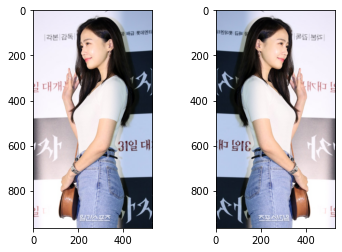

In [235]:
### 본문과 무관한 cv2에서 사진 불러오고 반전하는 연습
plt.subplot(1,2,1)
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
# 좌우반전
plt.subplot(1,2,2)
img_flip = cv2.flip(img, 1)
plt.imshow( cv2.cvtColor(img_flip, cv2.COLOR_BGR2RGB) )
plt.show()

<class 'numpy.ndarray'>


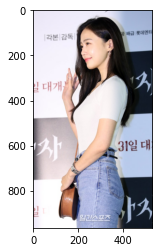

In [239]:
cap        = cv2.VideoCapture(video)
ret, frame = cap.read() 
# frame      = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) # 캡쳐.
frame      = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # 사진. yolo안돌아갈수있음
plt.imshow(frame)
print( type(frame) )

## Define Helper Fuctions


In [0]:
def get_mtcnn_face(img):
    start=time.time()
    bboxes=mtcnn.detect_faces(frame)[0]['box']
    x,y,w,h=bboxes
    bboxes=x,x+w,y,y+h
    return time.time()-start, bboxes
def get_blazeface_face(img):
    start=time.time()
    scale_w = img.shape[1] / 128.0 
    scale_h = img.shape[0] / 128.0
    blaze_output=blazeface.predict_on_image(cv2.resize(frame, (128,128)))
    blaze_bboxes=scale_boxes(get_blaze_boxes(blaze_output), scale_w, scale_h)
    if blaze_bboxes==[]:
        return time.time()-start,[]
    lx, ly, rx, ry = blaze_bboxes[0]
    bboxes=int(lx), int(rx), int(ly), int(ry)
    return time.time()-start, bboxes
def get_mobilenet_face(image):
    start=time.time()
    global boxes,scores,num_detections
    (im_height,im_width)=image.shape[:-1]
    imgs=np.array([image])
    (boxes, scores) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    max_=np.where(scores==scores.max())[0][0]
    box=boxes[0][max_]
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    return time.time()-start,(left, right, top, bottom)
def get_yolo_face(image):
    start=time.time()
    bbox=yolo_model.detect(frame, 0.7)
    bbox=get_boxes_points(bbox,frame.shape)[0]
    return time.time()-start,bbox

In [0]:
def annotate_image(frame,bbox,color):
    if bbox==[]:
        return frame
    frame=frame.copy()
    return cv2.rectangle(frame,(bbox[0],bbox[2]),(bbox[1],bbox[3]),color,10)
def crop_image(frame,bbox):
    left, right, top, bottom=bbox
    return frame[top:bottom,left:right]

#### Warm up

In [0]:
_ = get_blazeface_face(frame)
_ = get_mtcnn_face(frame)
_ = get_mobilenet_face(frame)
# _ = get_yolo_face(frame)

# Speed Comparison


In [0]:
blaze_time,     blaze_bboxes     = get_blazeface_face(frame)
mtcnn_time,     mtcnn_bboxes     = get_mtcnn_face(frame)
mobilenet_time, mobilenet_bboxes = get_mobilenet_face(frame)
# yolo_time,      yolo_bboxes      = get_yolo_face(frame)

In [246]:
print( "MTCNN Detection Time:"     + str(mtcnn_time) )
print( "Yolo Detection Time:"      + str(yolo_time) )
print( "Mobilenet Detection Time:" + str(mobilenet_time) )
print( "BlazeFace Detection Time:" + str(blaze_time) )

MTCNN Detection Time:0.3150041103363037
Yolo Detection Time:0.5588953495025635
Mobilenet Detection Time:0.22137832641601562
BlazeFace Detection Time:0.020369291305541992


In [247]:
print( 'Mobilenet is '+str(mtcnn_time/mobilenet_time) + 'times faster than MTCNN' )
print( 'Blazeface is '+str(mobilenet_time/blaze_time) + 'times faster than Mobilenet' )
print( 'Mobilenet is '+str(yolo_time/mobilenet_time) + 'times faster than YOLO' )

Mobilenet is 1.4229220874330122times faster than MTCNN
Blazeface is 10.868239012114474times faster than Mobilenet
Mobilenet is 2.524616382058484times faster than YOLO


# Ability to Detect Face

In [223]:
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')

⚠️BlazeFace is unable to detect face in this frame.


# Accuracy Comparison

## Annotated Images

In [0]:
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0)) # Red: Mobilenet
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))# Green: MTCNN
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))# Blue: BlazeFace
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))# Purple: YOLO

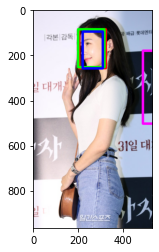

In [249]:
plt.imshow(annotated)

# Cropped Images

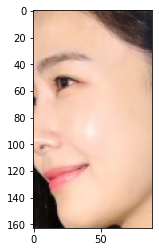

In [252]:
plt.imshow(crop_image(frame,blaze_bboxes))

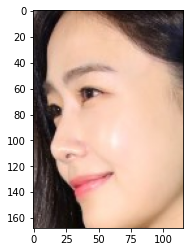

In [253]:
plt.imshow(crop_image(frame,mtcnn_bboxes))

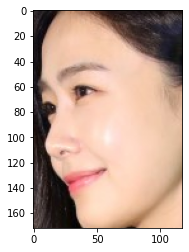

In [254]:
plt.imshow(crop_image(frame,mobilenet_bboxes))

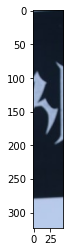

In [255]:
plt.imshow(crop_image(frame,yolo_bboxes))

# Extra Comparisons

MTCNN Detection Time:0.42880773544311523
Yolo Detection Time:0.38497090339660645
Mobilenet Detection Time:0.24502348899841309
BlazeFace Detection Time:0.019040346145629883
Mobilenet is 1.7500678698028516times faster than MTCNN
Blazeface is 12.868646773769424times faster than Mobilenet
Mobilenet is 1.5711591773109546times faster than YOLO


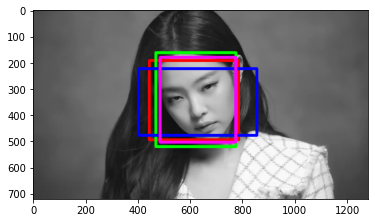

In [260]:
video=path+'jennie_grayscale.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

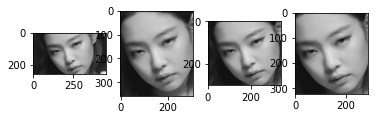

In [261]:
# 모아서 출력해보기
plt.subplot(1,4,1)
plt.imshow(crop_image(frame,blaze_bboxes))
plt.subplot(1,4,2)
plt.imshow(crop_image(frame,mtcnn_bboxes))
plt.subplot(1,4,3)
plt.imshow(crop_image(frame,mobilenet_bboxes))
plt.subplot(1,4,4)
plt.imshow(crop_image(frame,yolo_bboxes))
plt.show()

MTCNN Detection Time:0.16951680183410645
Mobilenet Detection Time:0.2381420135498047
BlazeFace Detection Time:0.023510456085205078
Mobilenet is 0.7118307236394217times faster than MTCNN
Blazeface is 10.129195821924753times faster than Mobilenet
Mobilenet is 1.6165602098434184times faster than YOLO
⚠️BlazeFace is unable to detect face in this frame.


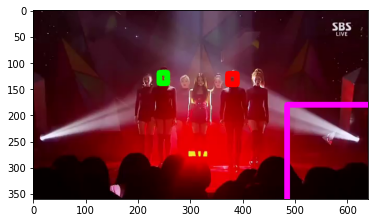

In [273]:
video=path+'jennie_mix.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
blaze_time,blaze_bboxes=get_blazeface_face(frame)
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
# yolo_time,yolo_bboxes=get_yolo_face(frame)  
print("MTCNN Detection Time:"+str(mtcnn_time))
# print("Yolo Detection Time:"+str(yolo_time))
print("Mobilenet Detection Time:"+str(mobilenet_time))
print("BlazeFace Detection Time:"+str(blaze_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/blaze_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if blaze_bboxes==[]:
    print('⚠️BlazeFace is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('⚠️MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('⚠️mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,blaze_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

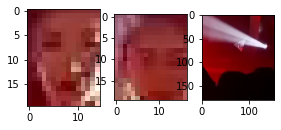

In [286]:
plt.subplot(1,4,1)
# plt.imshow(crop_image(frame, blaze_bboxes))
plt.subplot(1,4,2)
plt.imshow(crop_image(frame,mtcnn_bboxes))
plt.subplot(1,4,3)
plt.imshow(crop_image(frame,mobilenet_bboxes))
plt.subplot(1,4,4)
plt.imshow(crop_image(frame,yolo_bboxes))
plt.show()